# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [53]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error

from Functions import *

def prepend(list, str):
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)

### Define buffer size and input data filepath

In [2]:
buffer_size_m = 400
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)

### Read in data and drop spatial variables

In [21]:
# Read in data
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

In [51]:
datetimes = pd.read_csv(input_csv)['datetime']
datetimes = datetimes[0:2198889]

### Cut off data post-Covid

In [22]:
Xfull= Xfull[0:2198889]
Yfull= Yfull[0:2198889]
data_time_columns = data_time_columns[0:2198889]


In [23]:
# Drop the spatial features
Xfull.drop(['transport_stops','betweenness', 'lights',  'memorials', 'trees','bus-stops', 'tram-stops', 'metro-stations', 
            'taxi-ranks', 'big-car-parks', 'street_inf_Bicycle Rails', 'street_inf_Bollard','street_inf_Drinking Fountain',
            'street_inf_Floral Crate/Planter Box','street_inf_Horse Trough', 'street_inf_Information Pillar',
            'street_inf_Litter Bin', 'street_inf_Seat', 'street_inf_Tree Guard','landmarks_Community Use', 
            'landmarks_Mixed Use','landmarks_Place Of Assembly', 'landmarks_Place of Worship', 'landmarks_Retail', 
            'landmarks_Transport', 'landmarks_Education Centre','landmarks_Leisure/Recreation', 'landmarks_Office',
       'street_inf_Barbeque', 'street_inf_Hoop', 'street_inf_Picnic Setting', 'landmarks_Specialist Residential Accommodation',
       'landmarks_Vacant Land', 'landmarks_Purpose Built','landmarks_Health Services', 'avg_n_floors', 'buildings_Community Use',
       'buildings_Education', 'buildings_Entertainment', 'buildings_Events','buildings_Hospital/Clinic', 'buildings_Office', 'buildings_Parking',
       'buildings_Public Display Area', 'buildings_Residential','buildings_Retail', 'buildings_Storage', 'buildings_Unoccupied',
       'buildings_Working', 'buildings_Transport', 'distance_from_centre'], axis=1, inplace = True)

In [40]:
del Xfull['year']

### Find the mean hourly counts per hour

In [24]:
# Join the datetime column as this needed for the mean calculation
datetime_col = data_time_columns['datetime']
# Join date columns as they are needed for this analysis
data = pd.concat([Xfull, datetime_col], axis=1)
# Add hourly counts
data['hourly_counts'] = Yfull
# Find the mean count per hour
mean_hourly_counts =data.groupby(['datetime']).sum()

### Split back into X and Y variables

In [25]:
# The predictor variables
Xfull = mean_hourly_counts.drop(['hourly_counts'], axis =1)
# The variable to be predicted
Yfull = mean_hourly_counts['hourly_counts'].values

### Choose which date based variables to use

In [27]:
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
   'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
   'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

## Define model pipelines (linear regression, random forest and XGBoost)
Include process to scale the data

In [28]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 32)]])

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validatio

In [29]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

## Validation manually 

In [49]:
train_index = Xfull[0:int(len(Xfull)*0.8)].index.tolist()
test_index = Xfull[int(len(Xfull)*0.8):].index.tolist()

In [56]:
# Lists to store the scores
mae_scores = []
rmse_scores= []
r2_scores= []
neg_mae_scores = []
# Lists to store predicetd and actual values
predicted_values=[]
observed_values = []
# List to store the datetimes
datetimes_used = []

In [57]:
Xfull.reset_index(drop=True, inplace=True)

In [58]:
start = time()

# Get train and testing data for this fold
print(f"train index: {len(train_index)}")
print(f"test index: {len(test_index)}")
print(f"percentage of data used as testing: {round(len(test_index)/len(train_index)*100,1)}")

X_train, X_test = Xfull.iloc[train_index], Xfull.iloc[test_index]
y_train, y_test = Yfull[train_index], Yfull[test_index]
date_time_cols_train, date_time_cols_test =  data_time_columns.iloc[train_index], data_time_columns.iloc[test_index]

# Fit the model on the training data
rf_model_pipeline.fit(X_train, y_train)
# Use it to make predictions on the testing data, and store these
y_pred = rf_model_pipeline.predict(X_test)
predicted_values.append(y_pred)
# Store the datetimes
datetimes_used.append(datetimes[train_index])
# Store the actual values for the testing data
observed_values.append(y_test)
# Calculate the error metrics for this fold and append to the scores lists
mae_scores.append(mean_absolute_error(y_test, y_pred))
r2_scores.append(r2_score(y_test, y_pred))
rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
neg_mae_scores = [-score for score in mae_scores]        

end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))

train index: 57519
test index: 14380
percentage of data used as testing: 25.0
Ran cross_val_predict in 0 minutes


In [59]:
predicted_values_all = []
observed_values_all= []
for i in range(len(predicted_values)):
    for j in range(len(predicted_values[i])):
        observed_values_all.append(observed_values[i][j])
        predicted_values_all.append(predicted_values[i][j])

## Print scores

In [60]:
print(f"Mean absoloute error: {mae_scores}")
print(f"Mean R2: {r2_scores}")
print(f"Mean RMSE: {rmse_scores}")

Mean absoloute error: [3657.8497468706537]
Mean R2: [0.8135969079575962]
Mean RMSE: [5378.208418011005]


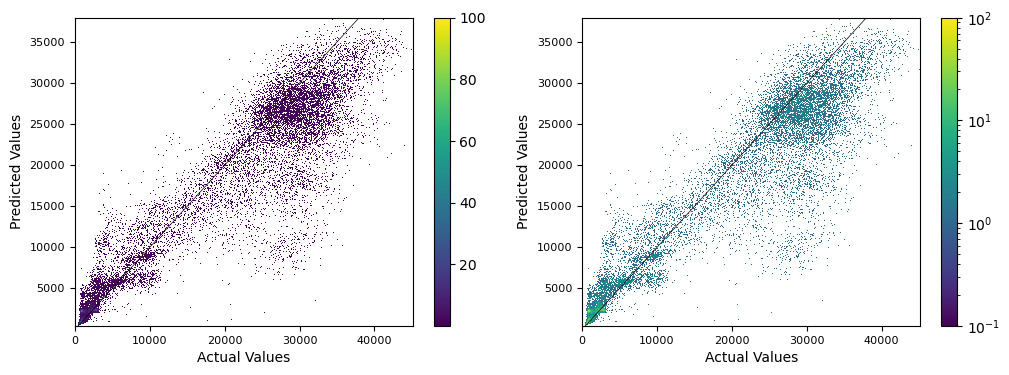

In [61]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], y_test, predicted_values_all, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], y_test, predicted_values_all, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

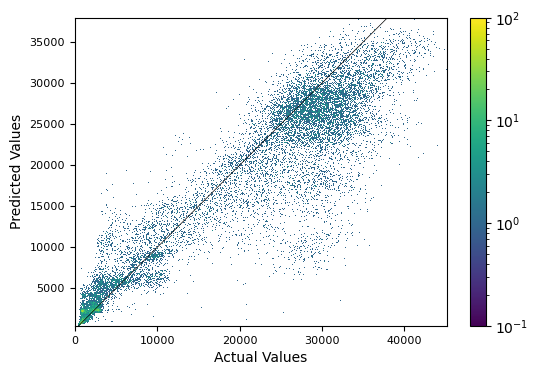

In [63]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, ax= plt.subplots(figsize = (6,4))

# Plot with log scale
using_datashader(ax, y_test, predicted_values_all, 'log')
ax.plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
ax.set_ylabel("Predicted Values", size=10)
ax.set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
ax.tick_params(axis='both', which='major', labelsize=8)

### Feature importances from within cross-validation
If reporting feature importances from the model, then would use those from fitting the final model on the full dataset. However, this is useful as a measure of the stability of the feature importances that the model reports

In [64]:
feature_importances_df = feature_importance_scores["rf_regressor_withsubtypes"].copy()
feature_importances_df.reset_index(inplace=True)
feature_importances_df.rename(columns={'level_0':'Variable'},inplace=True)

#### Top 10 features for each estimator

In [65]:
important_columns=pd.DataFrame()
for column in feature_importances_df.columns[1:]:
    this_col = feature_importances_df[['Variable', column]]
    important_columns[column] = this_col.sort_values(column, ascending = False)['Variable'].tolist()#[0:10]
important_columns    

,Estimator0,Estimator1,Estimator2,Estimator3,Estimator4,Estimator5,Estimator6,Estimator7,Estimator8,Estimator9
0,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time,Sin_time
1,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time,Cos_time
2,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num,Sin_weekday_num
3,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num,Cos_weekday_num
4,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure,Pressure
5,Temp,Temp,Temp,Temp,Temp,Temp,Temp,Temp,Temp,Temp
6,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num,Cos_month_num
7,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity,Humidity
8,random,Sin_month_num,random,random,random,random,random,random,random,random
9,Sin_month_num,random,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num,Sin_month_num


In [ ]:
pi_raw = []
pi_ls = []
for estimator in estimators:
    pi, pi_raw = find_permutation_importance(estimator['rf_regressor'], Xfull, Yfull, n_iter=3)  
    pi_ls.append(pi)
    pi_raw.append(pi_raw)

### Find permutation importance from within Cross validation

In [ ]:
important_columns=pd.DataFrame()
for i in list(range(0,len(pi_ls))):
    test=pi_ls[i].sort_values('importance', ascending = False)[0:25]
    test.reset_index(inplace=True, drop=True)
    important_columns["PI{}".format(i)] = test['feature']
important_columns